In [2]:
# This notebook includes the basic commands needed to read files into tecplot and save them as a numpy mesh pickle

# Essential Jupyter Notebook Magic
%matplotlib inline

# General Purpose and Data Handling Libraries
import os
import re
import glob
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
from natsort import natsorted
import pickle
from operator import add
import random
import math

# Tecplot for Scientific Data Visualization
import tecplot as tp
from tecplot.exception import *
from tecplot.constant import *

In [6]:
# Define Constants
amu = 1.67e-27
k_b = 1.38e-23
mu_0 = 1.257e-6
R_M = 2440e3 #m
m_p = 1.67e-27 # kg
e = 1.60218e-19 # C

# Define utility functions
def read_dataset(mypath,port=7605):
    # Reads in file "mypath" and returns a dataset object. May take a while for larger files.

    print("reading:",mypath)
    # First connect to TecPlot
    tp.session.connect(port=port)

    # Configure layout
    tp.new_layout()
    dataset = tp.data.load_tecplot(mypath)
    frame = tp.active_frame()
    frame.plot_type = PlotType.Cartesian3D

    # Return dataset
    return dataset

def MHD_to_numpy(dataset,x_axis,y_axis,z_axis,var_ls=["Bz"]):
    # Input: the path to a .plt file, and a list of variables to convert into a numpy meshgrid
    # Output: a dictionary of arrays, each labelled according to its name in var_ls
    # Var_ls should be *extensive*, so that this long process does not need to be rerun

    # Create an ordered zone`
    rect_zone = dataset.add_ordered_zone('rect_zone',[len(x_axis),len(y_axis),len(z_axis)])

    # Create 3D coordinate meshgrids
    xxx,yyy,zzz = np.meshgrid(x_axis,y_axis,z_axis)

    # Assign coordinate values to the rect_zone using the meshgrids
    rect_zone.values('X [[]R[]]')[:] = xxx.ravel()
    rect_zone.values('Y [[]R[]]')[:] = yyy.ravel()
    rect_zone.values('Z [[]R[]]')[:] = zzz.ravel()

    # Compute derivatives in tecplot, which does it efficiently
    # Compute plasma pressure gradient, in nPa / m
    if ("dp_dx" in var_ls) or ("dp_dy" in var_ls) or ("dp_dz" in var_ls):
        print("Computing ∇$p$")
        tp.data.operate.execute_equation(equation='{dp_dx} = (ddx({P [[]nPa[]]}))/2440000',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dp_dy} = (ddy({P [[]nPa[]]}))/2440000',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dp_dz} = (ddz({P [[]nPa[]]}))/2440000',
            ignore_divide_by_zero=True)
        
    # Compute magnetic field gradient , in nT / m
    if ("dB_dx" in var_ls) or ("dB_dy" in var_ls) or ("dB_dz" in var_ls): 
        print("Computing ∇B")
        tp.data.operate.execute_equation(equation='{dB_dx} = (ddx(({B_x [[]nT[]]}*{B_x [[]nT[]]}+{B_y [[]nT[]]}*{B_y [[]nT[]]}+{B_z [[]nT[]]}*{B_z [[]nT[]]})**(0.5)))/2440000',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dB_dy} = (ddy(({B_x [[]nT[]]}*{B_x [[]nT[]]}+{B_y [[]nT[]]}*{B_y [[]nT[]]}+{B_z [[]nT[]]}*{B_z [[]nT[]]})**(0.5)))/2440000',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dB_dz} = (ddz(({B_x [[]nT[]]}*{B_x [[]nT[]]}+{B_y [[]nT[]]}*{B_y [[]nT[]]}+{B_z [[]nT[]]}*{B_z [[]nT[]]})**(0.5)))/2440000',
            ignore_divide_by_zero=True)

    # Compute advective derivative (u . del) u
    if ("dux_dx" in var_ls):
        print("Computing jacobian for $(u_i\cdot∇)u_i$")
        tp.data.operate.execute_equation(equation='{dux_dx} = (ddx({U_x [km/s]}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duy_dx} = (ddx({U_y [km/s]}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duz_dx} = (ddx({U_z [km/s]}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dux_dy} = (ddy({U_x [km/s]}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duy_dy} = (ddy({U_y [km/s]}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duz_dy} = (ddy({U_z [km/s]}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dux_dz} = (ddz({U_x [km/s]}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duy_dz} = (ddz({U_y [km/s]}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duz_dz} = (ddz({U_z [km/s]}))/2440000', # km/s /m
            ignore_divide_by_zero=True)

    print("Beginning interpolation...")
    # Interpolate onto rect_zone
    tp.data.operate.interpolate_linear(source_zones=[0],
        destination_zone=1,
        fill_value=0)

    # Define dictionary to save results
    data3d = {"X":xxx,"Y":yyy,"Z":zzz}

    # Add all variables to data
    for var in var_ls:
        data3d[var] = rect_zone.values(var).as_numpy_array().reshape(xxx.shape)

    # Save in place
    print("Extraction complete! Saving 3D data ...")
    save_file = open(str(my_file[:-4]+"_TEST"), 'wb') 
    pickle.dump(data3d, save_file) 
    print("Done!")

    return data3d

In [7]:
# Example call
MHD_var_ls = ["Rho [[]amu/cm^3[]]","U_x [[]km/s[]]","U_y [[]km/s[]]","U_z [[]km/s[]]","B_x [[]nT[]]","B_y [[]nT[]]","B_z [[]nT[]]",
             "P [[]nPa[]]","J_x [[]`mA/m^2[]]","J_y [[]`mA/m^2[]]","J_z [[]`mA/m^2[]]"]#,"dp_dx","dp_dy","dp_dz",
              #"dB_dx","dB_dy","dB_dz","dux_dx","duy_dx","duz_dx","dux_dy","duy_dy","duz_dy","dux_dz","duy_dz","duz_dz"]

my_file = "/Volumes/My Book Duo/runs/DR_run1/ta-2/3d__var_3_t00000320_n00939179.plt"
x_axis = np.linspace(-10,5,75)
y_axis = np.linspace(-3,3,30)
z_axis = np.linspace(-3,3,30)

# Read in dataset
dataset = read_dataset(my_file,port=7600)

data = MHD_to_numpy(dataset,x_axis,y_axis,z_axis,var_ls=MHD_var_ls)

reading: /Volumes/My Book Duo/runs/DR_run1/ta-2/3d__var_3_t00000320_n00939179.plt
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Beginning interpolation...
Extraction complete! Saving 3D data ...
Done!


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_32456/1721186423.py:17: RuntimeWarning: divide by zero encountered in log
  ax.imshow(np.log(P[iy,:,:].T),origin='lower',extent = [np.min(X),np.max(X),np.min(Z),np.max(Z)])
/Users/atcushen/Library/Python/3.9/lib/python/site-packages/matplotlib/patches.py:3421: RuntimeWarning: invalid value encountered in scalar divide
  cos_t, sin_t = head_length / head_dist, head_width / head_dist


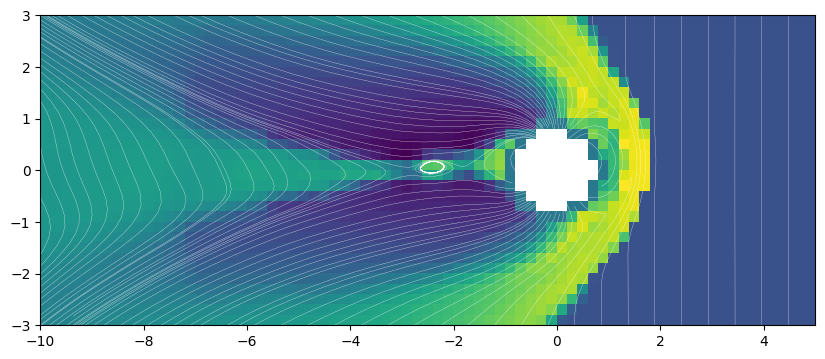

In [23]:
# Example plot
fig,ax = plt.subplots(figsize=(10,8))

# Unpack data
X = data["X"]
Y = data["Y"]
Z = data["Z"]
P = data["P [[]nPa[]]"]
Bx = data["B_x [[]nT[]]"]
Bz = data["B_z [[]nT[]]"]

# Get the index for a given slice
# NOTE: for a combination of reasons, the 3d mesh structure I have is a bit unconventional
# The indices e.g. P[a,b,c] represent (y,x,z)
# So to extract the cell at index xi along the x axis, yi along the y axis, zi along the z axis, you use:
# val = P[yi,xi,zi]
yslice = 0
iy = np.where(data["Y"][:,0,0]>yslice)[0][0] # So here, to get yi, I look along [:,0,0], which is the y axis (not the x axis)

# plot
ax.imshow(np.log(P[iy,:,:].T),origin='lower',extent = [np.min(X),np.max(X),np.min(Z),np.max(Z)])
ax.streamplot(*np.meshgrid(x_axis,z_axis),Bx[iy,:,:].T,Bz[iy,:,:].T,broken_streamlines = False,color='white',linewidth = 0.2,arrowsize=0)
# I use the meshgrid command again because streamplot needs equally spaced cells, and for whatever reason the pytecplot mapping
# moves cells coordinates around very very slightly